<a href="https://colab.research.google.com/github/LIYunzhe1408/Facial-Keypoint-Detection/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data

In [1]:
# Fetch data
!mkdir data
!wget -P data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n data/train-test-data.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/test/Elmar_Brok_30.jpg  
  inflating: data/test/Elmar_Brok_31.jpg  
  inflating: data/test/Elsa_Zylberstein_00.jpg  
  inflating: data/test/Elsa_Zylberstein_01.jpg  
  inflating: data/test/Elsa_Zylberstein_10.jpg  
  inflating: data/test/Elsa_Zylberstein_11.jpg  
  inflating: data/test/Elsa_Zylberstein_40.jpg  
  inflating: data/test/Elsa_Zylberstein_41.jpg  
  inflating: data/test/Elton_John_10.jpg  
  inflating: data/test/Elton_John_11.jpg  
  inflating: data/test/Elton_John_20.jpg  
  inflating: data/test/Elton_John_21.jpg  
  inflating: data/test/Elton_John_30.jpg  
  inflating: data/test/Elton_John_31.jpg  
  inflating: data/test/Elton_John_40.jpg  
  inflating: data/test/Elton_John_41.jpg  
  inflating: data/test/Emile_Lahoud_00.jpg  
  inflating: data/test/Emile_Lahoud_01.jpg  
  inflating: data/test/Emile_Lahoud_30.jpg  
  inflating: data/test/Emile_Lahoud_31.jpg  
  inflating: data/test/Emile_Lahoud_40.jpg  


# Setup Environment

In [2]:
# No need if you are using colab

# !pip install matplotlib~=3.5.2
# !pip install scikit-image==0.19.2
# !pip install torch~=1.8.1
# !pip install torchvision~=0.9.1
# !pip install numpy~=1.21.6
# !pip install pillow~=9.1.1
# !pip install tqdm~=4.64.0
# !pip install jupyter==1.0.0
# !pip install opencv-python==4.6.0.66
# !pip install pandas==1.3.5


# Visualize the data

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


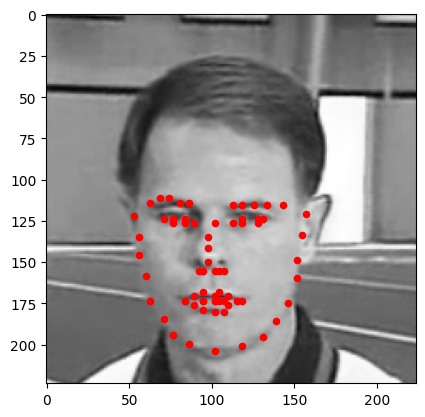

In [3]:
# importing the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
from tqdm import tqdm


# the transforms we defined in Notebook 1 are in the helper file `custom_transforms.py`
from custom_transforms import (
    Rescale,
    RandomCrop,
    NormalizeOriginal,
    ToTensor,
)

# the dataset we created in Notebook 1
from facial_keypoints_dataset import FacialKeypointsDataset



# defining the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose(
    [Rescale(250), RandomCrop(224), NormalizeOriginal(), ToTensor()]
)

training_keypoints_csv_path = os.path.join("data", "training_frames_keypoints.csv")
training_data_dir = os.path.join("data", "training")
test_keypoints_csv_path = os.path.join("data", "test_frames_keypoints.csv")
test_data_dir = os.path.join("data", "test")


# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(
    csv_file=training_keypoints_csv_path,
    root_dir=training_data_dir,
    transform=data_transform,
)
# load training data in batches
batch_size = 32
train_loader = DataLoader(
    transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

# creating the test dataset
test_dataset = FacialKeypointsDataset(
    csv_file=test_keypoints_csv_path,
    root_dir=test_data_dir,
    transform=data_transform
)
# loading test data in batches
batch_size = 32
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

for i, data in enumerate(test_loader):
    sample = data
    image = sample['image'][0]
    keypoints = sample['keypoints'][0]
    # plot the image black and white
    plt.imshow(image.numpy().transpose(1, 2, 0), cmap='gray')
    plt.scatter(keypoints[:, 0]*50+100, keypoints[:, 1]*50+100, c='r', s=20)
    plt.show()
    break


# Train your model

In [4]:
from models import SimpleNet, Resnet18Grayscale
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ========== VALIDATION FUNCTION ==========
def validate(net, val_loader, criterion):
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images = data["image"].cuda()
            key_pts = data["keypoints"].view(-1, 136).cuda()

            if isinstance(criterion, nn.MSELoss):
                images = images.type(torch.float32)
                key_pts = key_pts.type(torch.float32)

            outputs = net(images)
            loss = criterion(outputs, key_pts)
            val_loss += loss.item()

    return val_loss / len(val_loader)


# ========== TRAINING FUNCTION ==========
def train_net(net, n_epochs, criterion, optimizer, val_loader):
    train_losses = []
    val_losses = []

    net.train()
    net.cuda()

    for epoch in tqdm(range(n_epochs), desc="training"):
        running_loss = 0.0

        for data in tqdm(train_loader, desc=f"epoch {epoch}"):
            images = data["image"].cuda()
            key_pts = data["keypoints"].cuda()

            if isinstance(criterion, nn.MSELoss):
                images = images.type(torch.float32)
                key_pts = key_pts.type(torch.float32)

            key_pts = key_pts.view(key_pts.size(0), -1)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, key_pts)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Compute epoch-level losses
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        epoch_val_loss = validate(net, val_loader, criterion)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses


# ===================================
# Part 1 Net
# Loss Function
# net_SmoothL1 = SimpleNet()
# net_MSELoss = SimpleNet()

# net_batch_64 = SimpleNet()
# net_LR_05 = SimpleNet()
# net_LR_00005 = SimpleNet()

# net_AdamW = SimpleNet()
# net_dropout_all_02 = SimpleNet()

# ===================================
# Part 2 ResNet
net = Resnet18Grayscale()


# ========== HYPERPARAMETERS ==========
n_epochs = 10
# optimizer_smoothL1 = optim.Adam(net_LR_00005.parameters(), lr=0.0005)
# optimizer_MSE = optim.Adam(net_MSELoss.parameters(), lr=0.001)
# optimizer = optim.AdamW(net_dropout_all_02.parameters(), lr=0.0005)
optimizer = optim.AdamW(net.parameters(), lr=0.0005)

# ========== TRAIN MODELS ==========
# Loss Function
# SmoothL1_losses, val_SmoothL1_losses = train_net(net_SmoothL1, n_epochs, nn.SmoothL1Loss(), optimizer_smoothL1, test_loader)
# MSE_losses, val_MSE_losses = train_net(net_MSELoss, n_epochs, nn.MSELoss(), optimizer_MSE, test_loader)

# Batch Size
# LR_05_L1_loss, LR_05_L1_val_loss = train_net(net_LR_00005, n_epochs, nn.SmoothL1Loss(), optimizer_smoothL1, test_loader)

# AdamW_loss, AdamW_val_loss = train_net(net_AdamW, n_epochs, nn.SmoothL1Loss(), optimizer, test_loader)

# droupout_all_02_loss, droupout_all_02_val_loss = train_net(net_dropout_all_02, n_epochs, nn.SmoothL1Loss(), optimizer, test_loader)

# =================================Resnet
resnet18_loss, resnet18_val_loss = train_net(net, n_epochs, nn.SmoothL1Loss(), optimizer, test_loader)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
# from models import SimpleNet

# net_SmoothL1 = SimpleNet()
# net_MSELoss = SimpleNet()
# # net = Resnet18Grayscale()
# # net = Dinov2_grayscale()


# def train_net(net, n_epochs, criterion, optimizer):
#     losses = []
#     # prepare the net for training
#     net.train()
#     net.cuda()

#     # loop over the dataset multiple times
#     for epoch in tqdm(range(n_epochs), desc="training"):

#         running_loss = 0.0

#         # train on batches of data, assumes we already have train_loader
#         batch_i = 0
#         for data in tqdm(train_loader, desc="epoch {}".format(epoch)):

#             # get the input images and their corresponding labels
#             images = data["image"]
#             key_pts = data["keypoints"]
#             # Move images and keypoints to GPU
#             images = images.cuda()
#             key_pts = key_pts.cuda()

#             if isinstance(criterion, nn.MSELoss):
#               images = images.type(torch.float32)
#               key_pts = key_pts.type(torch.float32)

#             # TODO: implement training code here
#             key_pts = key_pts.view(key_pts.size(0), -1)

#             optimizer.zero_grad()              # zero the parameter gradients
#             outputs = net(images)              # forward pass
#             loss = criterion(outputs, key_pts) # compute loss
#             loss.backward()                    # backward pass
#             optimizer.step()                   # update weights

#             # print loss statistics
#             running_loss += loss.item()

#             batch_i += 1

#         epoch_loss = running_loss / len(train_loader)
#         losses.append(epoch_loss)

#     return losses
#     print("Finished Training")

# # train the network
# n_epochs = 2  # we start at small values, then we increase when we fixed the model structure and hyperparams

# # Defining the loss and optimization
# criterion = nn.SmoothL1Loss()
# criterion = nn.MSELoss()
# optimizer_smoothL1 = optim.Adam(net_SmoothL1.parameters(), lr=0.001)
# optimizer_MSE = optim.Adam(net_MSELoss.parameters(), lr=0.001)

# SmoothL1_losses = train_net(net_SmoothL1, n_epochs, nn.SmoothL1Loss(), optimizer_smoothL1)
# MSE_losses = train_net(net_MSELoss, n_epochs, nn.MSELoss(), optimizer_MSE)

training: 100%|██████████| 2/2 [00:30<00:00, 15.18s/it]


# Visualize the model predictions

## Loss function

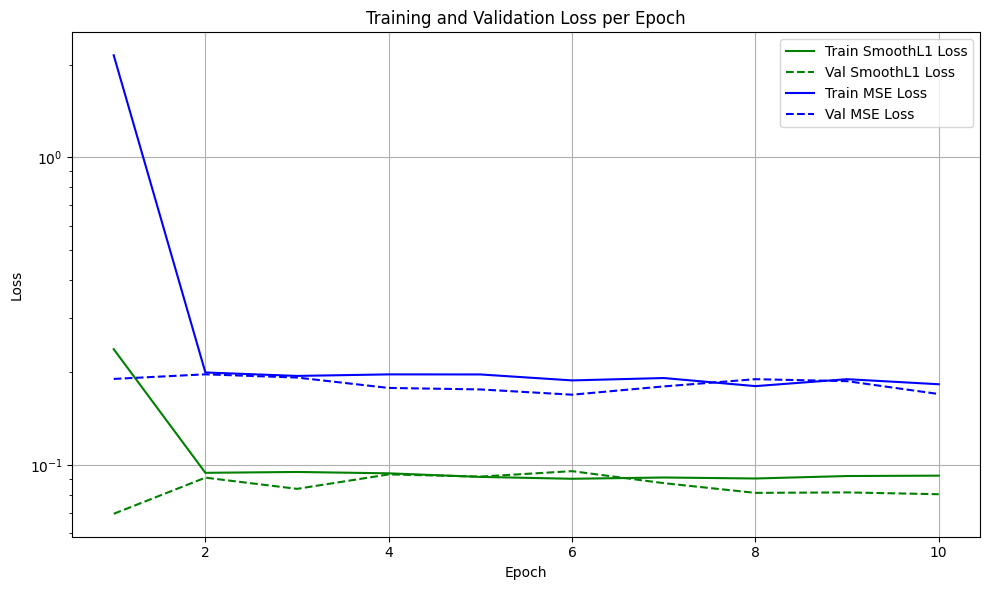

Final training loss: 0.09242875540443223, 0.18315610224338172
Final val loss: 0.08044344028357801, 0.17023054251865466
Best val loss (SmoothL1): 0.06948532591530011, epoch#: 0
Best val loss (MSE): 0.1693831400147506, epoch#: 5


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(SmoothL1_losses) + 1)

# plt.figure(figsize=(10, 6))

# # SmoothL1 loss curves
# plt.plot(epochs, SmoothL1_losses, label='Train SmoothL1 Loss', color='green', linestyle='-')
# plt.plot(epochs, val_SmoothL1_losses, label='Val SmoothL1 Loss', color='green', linestyle='--')

# # MSE loss curves
# plt.plot(epochs, MSE_losses, label='Train MSE Loss', color='blue', linestyle='-')
# plt.plot(epochs, val_MSE_losses, label='Val MSE Loss', color='blue', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {SmoothL1_losses[-1]}, {MSE_losses[-1]}')
# print(f'Final val loss: {val_SmoothL1_losses[-1]}, {val_MSE_losses[-1]}')

# best_val_loss = min(val_SmoothL1_losses)
# best_epoch = val_SmoothL1_losses.index(best_val_loss)
# print(f'Best val loss (SmoothL1): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(val_MSE_losses)
# best_epoch = val_MSE_losses.index(best_val_loss)
# print(f'Best val loss (MSE): {best_val_loss}, epoch#: {best_epoch}')


## Batch Size

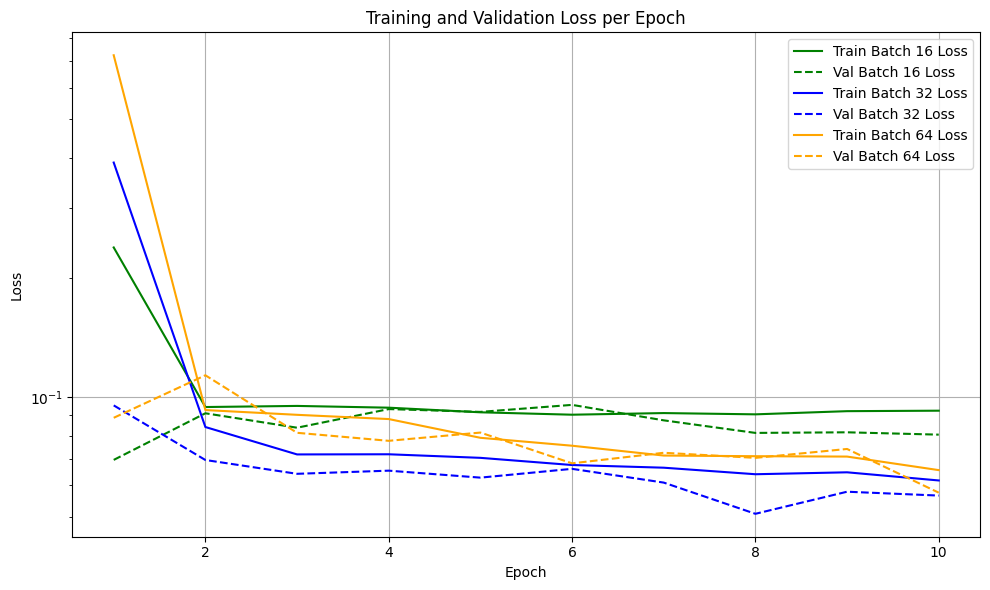

Final training loss: 0.09242875540443223, 0.06167978404789199, 0.06548963366943926
Final val loss: 0.08044344028357801, 0.056507733884966695, 0.05746516709373932
Best val loss (Batch 16): 0.06948532591530011, epoch#: 0
Best val loss (Batch 32): 0.05084166460482429, epoch#: 7
Best val loss (Batch 64): 0.05746516709373932, epoch#: 9


In [ ]:
# batch_16_L1_loss = SmoothL1_losses
# batch_16_L1_val_loss = val_SmoothL1_losses
# batch_16_L1_net = net_SmoothL1

# import matplotlib.pyplot as plt

# epochs = range(1, len(batch_16_L1_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, batch_16_L1_loss, label='Train Batch 16 Loss', color='green', linestyle='-')
# plt.plot(epochs, batch_16_L1_val_loss, label='Val Batch 16 Loss', color='green', linestyle='--')

# # 32 loss curves
# plt.plot(epochs, batch_32_L1_loss, label='Train Batch 32 Loss', color='blue', linestyle='-')
# plt.plot(epochs, batch_32_L1_val_loss, label='Val Batch 32 Loss', color='blue', linestyle='--')

# # 64 loss curves
# plt.plot(epochs, batch_64_L1_loss, label='Train Batch 64 Loss', color='orange', linestyle='-')
# plt.plot(epochs, batch_64_L1_val_loss, label='Val Batch 64 Loss', color='orange', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {batch_16_L1_loss[-1]}, {batch_32_L1_loss[-1]}, {batch_64_L1_loss[-1]}')
# print(f'Final val loss: {batch_16_L1_val_loss[-1]}, {batch_32_L1_val_loss[-1]}, {batch_64_L1_val_loss[-1]}')

# best_val_loss = min(batch_16_L1_val_loss)
# best_epoch = batch_16_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Batch 16): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(batch_32_L1_val_loss)
# best_epoch = batch_32_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Batch 32): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(batch_64_L1_val_loss)
# best_epoch = batch_64_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Batch 64): {best_val_loss}, epoch#: {best_epoch}')

## Learning Rate

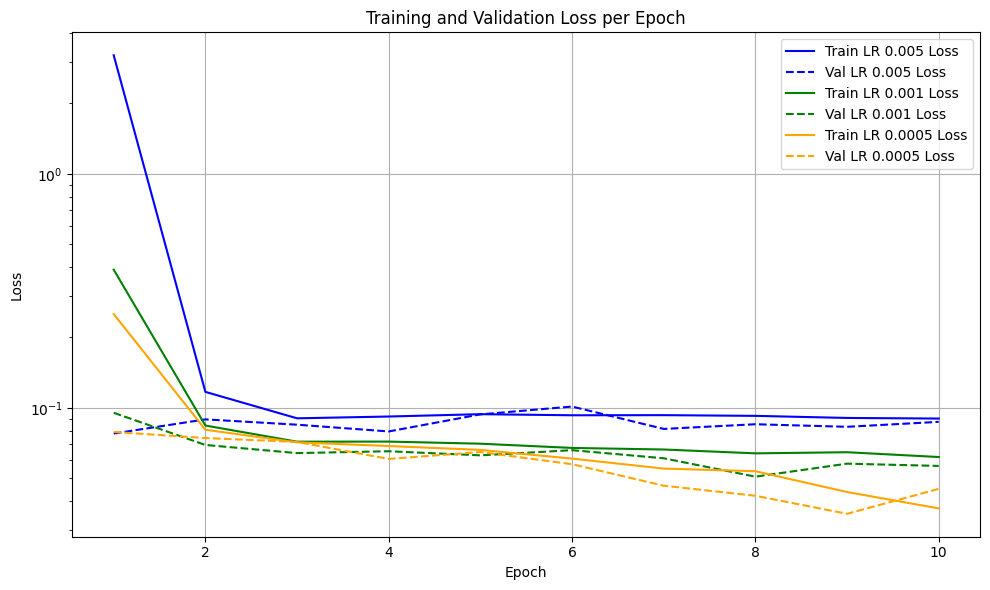

Final training loss: 0.037213279466794265, 0.06167978404789199, 0.09005379214909241
Final val loss: 0.04509976361784689, 0.056507733884966695, 0.08716710537090032
Best val loss (LR 0.005): 0.035286272131784334, epoch#: 8
Best val loss (LR 0.001): 0.05084166460482429, epoch#: 7
Best val loss (LR 0.0005): 0.07772143766586313, epoch#: 0


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(LR_05_L1_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, LR_00005_L1_loss, label='Train LR 0.005 Loss', color='blue', linestyle='-')
# plt.plot(epochs, LR_00005_L1_val_loss, label='Val LR 0.005 Loss', color='blue', linestyle='--')

# # 32 loss curves
# plt.plot(epochs, batch_32_L1_loss, label='Train LR 0.001 Loss', color='green', linestyle='-')
# plt.plot(epochs, batch_32_L1_val_loss, label='Val LR 0.001 Loss', color='green', linestyle='--')

# # # 64 loss curves
# plt.plot(epochs, LR_05_L1_loss, label='Train LR 0.0005 Loss', color='orange', linestyle='-')
# plt.plot(epochs, LR_05_L1_val_loss, label='Val LR 0.0005 Loss', color='orange', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {LR_05_L1_loss[-1]}, {batch_32_L1_loss[-1]}, {LR_00005_L1_loss[-1]}')
# print(f'Final val loss: {LR_05_L1_val_loss[-1]}, {batch_32_L1_val_loss[-1]}, {LR_00005_L1_val_loss[-1]}')

# best_val_loss = min(LR_05_L1_val_loss)
# best_epoch = LR_05_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (LR 0.005): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(batch_32_L1_val_loss)
# best_epoch = batch_32_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (LR 0.001): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(LR_00005_L1_val_loss)
# best_epoch = LR_00005_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (LR 0.0005): {best_val_loss}, epoch#: {best_epoch}')

## Optimizer

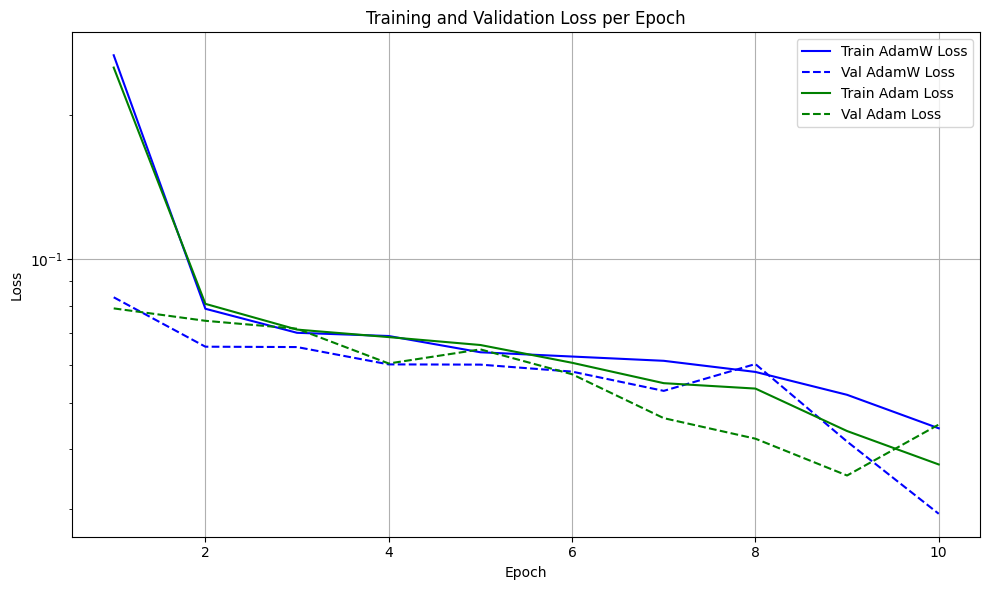

Final training loss: 0.037213279466794265, 0.04429485004647331
Final val loss: 0.04509976361784689, 0.02934233347240932
Best val loss (Adam): 0.035286272131784334, epoch#: 8
Best val loss (AdamW): 0.02934233347240932, epoch#: 9


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(LR_05_L1_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, AdamW_loss, label='Train AdamW Loss', color='blue', linestyle='-')
# plt.plot(epochs, AdamW_val_loss, label='Val AdamW Loss', color='blue', linestyle='--')

# # # 64 loss curves
# plt.plot(epochs, LR_05_L1_loss, label='Train Adam Loss', color='green', linestyle='-')
# plt.plot(epochs, LR_05_L1_val_loss, label='Val Adam Loss', color='green', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {LR_05_L1_loss[-1]}, {AdamW_loss[-1]}')
# print(f'Final val loss: {LR_05_L1_val_loss[-1]}, {AdamW_val_loss[-1]}')

# best_val_loss = min(LR_05_L1_val_loss)
# best_epoch = LR_05_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Adam): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(AdamW_val_loss)
# best_epoch = AdamW_val_loss.index(best_val_loss)
# print(f'Best val loss (AdamW): {best_val_loss}, epoch#: {best_epoch}')

In [ ]:
# import json

# with open("adamw_losses.json", "w") as f:
#     json.dump({
#         "train_loss": AdamW_loss,
#         "val_loss": AdamW_val_loss
#     }, f)

## Droupout

In [ ]:
import json
with open("adamw_losses.json", "r") as f:
    loss_data = json.load(f)

AdamW_loss = loss_data["train_loss"]
AdamW_val_loss = loss_data["val_loss"]

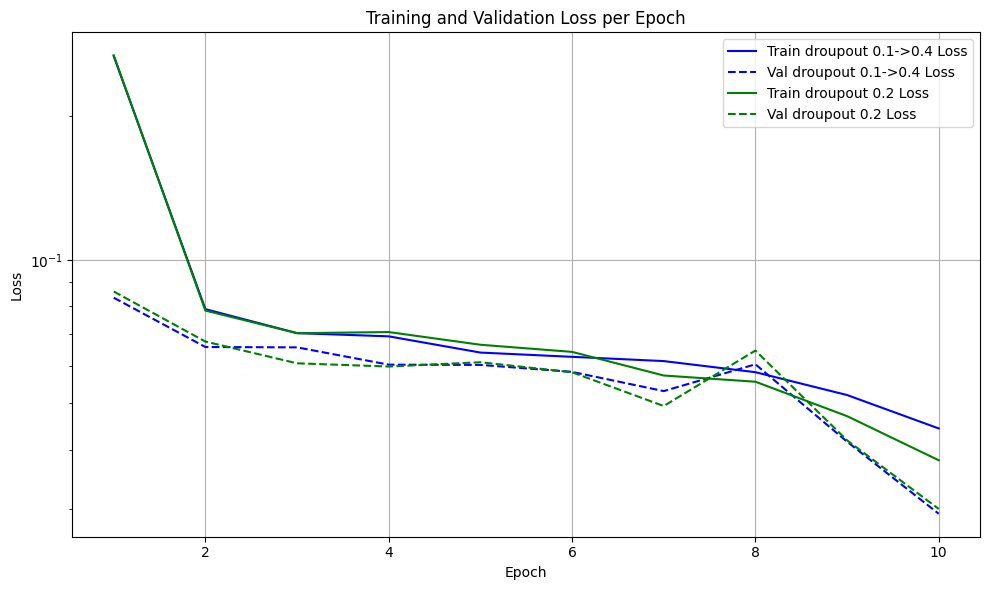

Final training loss: 0.03798806185916372, 0.04429485004647331
Final val loss: 0.030033955374372284, 0.02934233347240932
Best val loss (all 0.2): 0.030033955374372284, epoch#: 9
Best val loss (0.1->0.4): 0.02934233347240932, epoch#: 9


In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(AdamW_loss) + 1)

plt.figure(figsize=(10, 6))

# 16 loss curves
plt.plot(epochs, AdamW_loss, label='Train droupout 0.1->0.4 Loss', color='blue', linestyle='-')
plt.plot(epochs, AdamW_val_loss, label='Val droupout 0.1->0.4 Loss', color='blue', linestyle='--')

# # 64 loss curves
plt.plot(epochs, droupout_all_02_loss, label='Train droupout 0.2 Loss', color='green', linestyle='-')
plt.plot(epochs, droupout_all_02_val_loss, label='Val droupout 0.2 Loss', color='green', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Final training loss: {droupout_all_02_loss[-1]}, {AdamW_loss[-1]}')
print(f'Final val loss: {droupout_all_02_val_loss[-1]}, {AdamW_val_loss[-1]}')

best_val_loss = min(droupout_all_02_val_loss)
best_epoch = droupout_all_02_val_loss.index(best_val_loss)
print(f'Best val loss (all 0.2): {best_val_loss}, epoch#: {best_epoch}')

best_val_loss = min(AdamW_val_loss)
best_epoch = AdamW_val_loss.index(best_val_loss)
print(f'Best val loss (0.1->0.4): {best_val_loss}, epoch#: {best_epoch}')

In [ ]:
from torch.nn import MSELoss

def calcMSE(net):
  net.eval()
  net.cuda()
  mse = MSELoss()
  total_mse = 0.0
  with torch.no_grad():
      for data in test_loader:
          images = data['image'].cuda()
          key_pts = data['keypoints'].view(-1, 136).cuda()
          outputs = net(images)
          total_mse += mse(outputs, key_pts).item()

  mean_mse = total_mse / len(test_loader)
  print(f"Test Mean Squared Error: {mean_mse:.4f}")
# calcMSE(batch_16_L1_net)
# calcMSE(net_batch_32)
# calcMSE(net_LR_05)
# calcMSE(net_LR_00005)
# calcMSE(net_AdamW)
# calcMSE(net_batch_64)
calcMSE(net_dropout_all_02)

Test Mean Squared Error: 0.0775


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


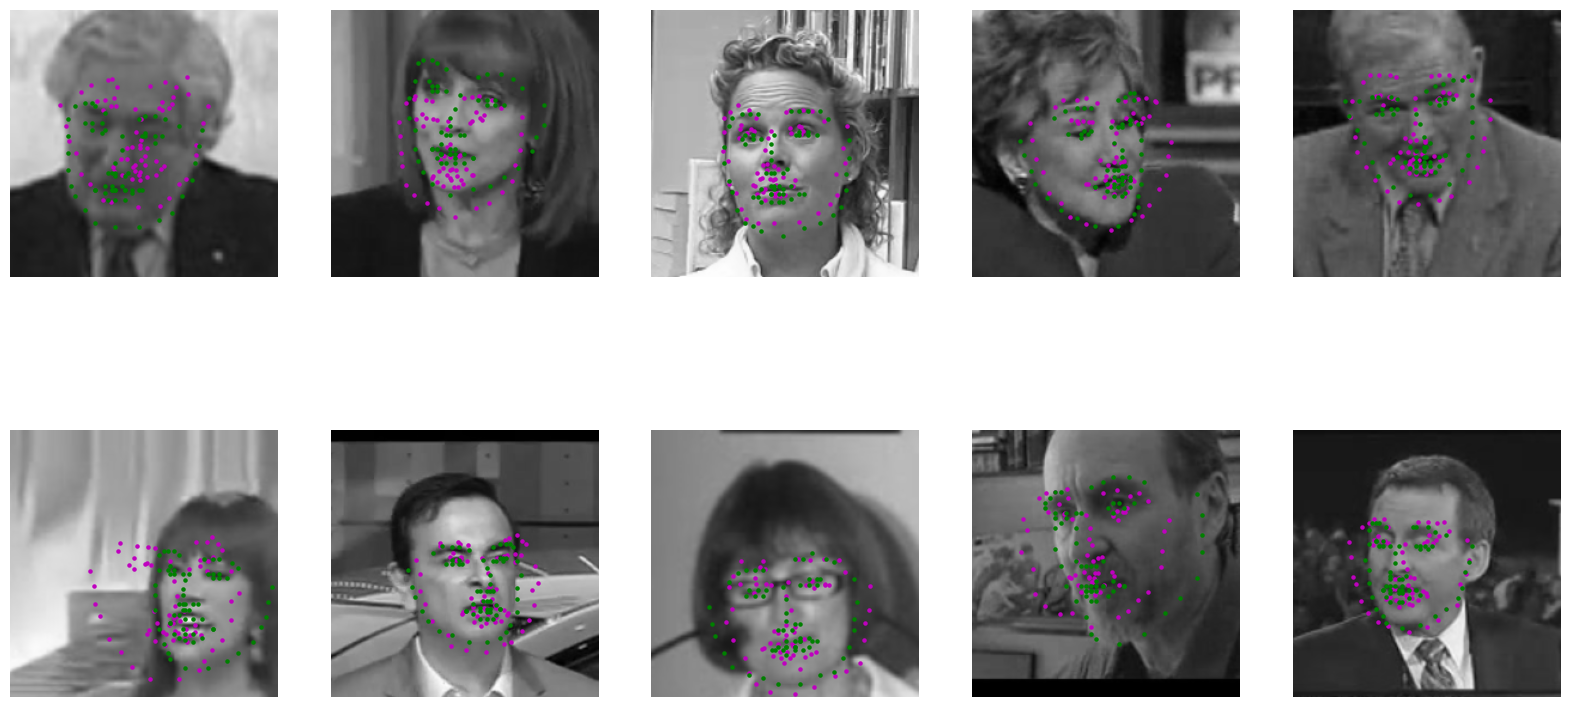

In [ ]:

def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """
    Show image with predicted keypoints and optionally ground truth keypoints
    """
    # Convert grayscale to RGB if needed
    if len(image.shape) == 2:
        image = np.stack([image]*3, axis=2)

    plt.imshow(image*255, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')

    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


# test the model on a batch of test images
def net_sample_output(model, test_loader):

    # iterate through the test dataset
    for i, sample in enumerate(test_loader):

        # getting sample data: images and ground truth keypoints
        images = sample["image"]
        key_pts = sample["keypoints"]

        # converting images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forwarding pass to get net output
        output_pts = model(images)

        # reshaping to batch_size x 68 x 2 pts # (136*1) => (68*2)
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)

        # break after first image is tested
        if i == 0:
            return (
                images,
                output_pts,
                key_pts,
            )  # images, predicted key points, real keypoints

# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    plt.figure(figsize=(20, 10))
    for i in range(batch_size):
        ax = plt.subplot(batch_size // 5, 5, i + 1)

        # un-transform the image data
        image = test_images[i].data  # get the image from its Variable wrapper
        image = image.numpy()  # convert to numpy array from a Tensor
        image = np.transpose(
            image, (1, 2, 0)
        )  # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()

        # undo normalization of keypoints
        predicted_key_pts = predicted_key_pts * 50.0 + 100

        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
            ground_truth_pts = ground_truth_pts * 50.0 + 100

        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)

        plt.axis("off")

    plt.show()


net = net_dropout_all_02
# get a sample of test data again
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
test_images, test_outputs, gt_pts = net_sample_output(net.cpu(), test_loader)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

# visualize the test output
visualize_output(test_images, test_outputs, gt_pts)

# Training UNet with Heatmaps

In [ ]:
# importing the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
from tqdm import tqdm


# the transforms we defined in Notebook 1 are in the helper file `custom_transforms.py`
from custom_transforms import (
    Rescale,
    RandomCrop,
    NormalizeOriginal,
    ToTensor,
)

# the dataset we created in Notebook 1
from facial_keypoints_dataset import FacialKeypointsHeatmapDataset



# defining the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose(
    [Rescale(250), RandomCrop(224), NormalizeOriginal(), ToTensor()]
)

training_keypoints_csv_path = os.path.join("data", "training_frames_keypoints.csv")
training_data_dir = os.path.join("data", "training")
test_keypoints_csv_path = os.path.join("data", "test_frames_keypoints.csv")
test_data_dir = os.path.join("data", "test")


# create the transformed dataset
transformed_dataset = FacialKeypointsHeatmapDataset(
    csv_file=training_keypoints_csv_path,
    root_dir=training_data_dir,
    transform=data_transform,
    output_size=224
)
# load training data in batches
batch_size = 16
train_loader = DataLoader(
    transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

# creating the test dataset
test_dataset = FacialKeypointsHeatmapDataset(
    csv_file=test_keypoints_csv_path,
    root_dir=test_data_dir,
    transform=data_transform,
    output_size=224
)
# loading test data in batches
batch_size = 16
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

for i, data in enumerate(test_loader):
    sample = data
    image = sample['image'][0]
    keypoints = sample['keypoints'][0]
    # plot the image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0), cmap='gray')
    plt.scatter(keypoints[:, 0]*50+100, keypoints[:, 1]*50+100, c='r', s=20)
    # show the heatmaps
    plt.subplot(1, 2, 2)
    heatmaps = sample['heatmaps'][0].sum(dim=0, keepdim=True)
    plt.imshow(heatmaps.numpy().transpose(1, 2, 0))
    plt.show()
    break


In [ ]:
# TODO: training code for UNet with heatmaps

In [ ]:
# TODO: visualize your predictions